In [1]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from importlib import reload

from sklearn import metrics
import seaborn as sns
sns.set()


from IPython.display import clear_output, display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from preproc_functions import pre_process

In [3]:
from model_functions import SplitModel

## Walk forward

In [4]:
def progress_bar(k, n, incr_txt="Step", bar_len = 10):

    bar_char  = u'\u25A5'
    line_char = u'\u21E2' # u'\u2192'  u'\u23AF' u'\u25AD'

    places   = int(np.ceil(n/bar_len))
    pct      = k/n
    n_str    = "{:,.0f}".format(n)
    k_str    = "{:,.0f}".format(k)
    pct_str  = "{:,.0f}%".format(k/n * 100)
    # d_format = "%" + str(places) + "d"

    if k == n-1:
        n_bars = bar_len
        n_spaces = 0
        text_txt = "Completed " + n_str + " " + incr_txt + "s."
    else:
        n_bars   = int(np.floor(pct * bar_len))
        n_spaces = bar_len - n_bars
        text_txt = " " + pct_str +  " (" + incr_txt + " " + k_str + " of  " + n_str + ")."

    bar_txt  = "[" + "".ljust(n_bars,bar_char) + "".rjust(n_spaces,line_char) + "]  "

    clear_output()
    display(bar_txt + text_txt)

In [5]:
def walk_forward_harness(df, start, date_col = 'Date', step_size = 1):
    predictions = []
    model_list = []
    group_list = []

    stats_list = []
    def_percent = []

    labels = []

    ### features for first firm
    first_features = [
        # 'asst_tot_quantile_values', ####
        'financial_leverage_quantile_values',
        'profitability_ratio_quantile_values',
        # 'net_income_growth_quantile_values',
        'quick_ratio_v2_quantile_values',
        # 'sales_growth_quantile_values',
        # 'cash_assets_ratio_quantile_values', ####
        'dscr_quantile_values',
        'roe_quantile_values',
        'cfo_quantile_values',
        # 'ebitda',
        # 'ateco_sector_pd',
        # 'sector_group_pd', ####
        # 'legal_struct_pd',
        'regional_code_pd' ####
    ]


    ### features for recurring firms
    rec_features = [
        # 'asst_tot_quantile_values', ###
        'financial_leverage_quantile_values',
        'profitability_ratio_quantile_values',
        'net_income_growth_quantile_values',
        'quick_ratio_v2_quantile_values',
        'sales_growth_quantile_values',
        # 'cash_assets_ratio_quantile_values',###
        'dscr_quantile_values',
        'roe_quantile_values',
        'cfo_quantile_values',
        # 'ebitda', ###
        # 'ateco_sector_pd',###
        # 'sector_group_pd',###
        # 'legal_struct_pd',###
        'regional_code_pd'
    ]


    with open('quantile_custom_bins.pkl', 'rb') as file:
        custom_bins = pickle.load(file)

    print(custom_bins)
    preproc_params = {
        'quantile_bins' : {},
        'quantile_values' : {},
        'category_pd': {}
    }

    # df[date_col] = pd.to_datetime(df[date_col])
    # walk_range = df[date_col].dt.year.unique()
    walk_range = df['fs_year'].unique()

    for i in range(start,len(walk_range), step_size):
        print(stats_list)

        train_idx = walk_range[:i]
        test_idx = [walk_range[i]]
        print('Training range:',train_idx)
        print('Test step:',test_idx)

        # print('train',train_idx)
        # print('test',test_idx)

        # train_data = df[df[date_col].dt.year.isin(train_idx)].copy()
        # test_data = df[df[date_col].dt.year.isin(test_idx)].copy()
        train_data = df[df['fs_year'].isin(train_idx)].copy()
        test_data = df[df['fs_year'].isin(test_idx)].copy()
        print(train_data.shape)
        print(test_data.shape)

        train_data_proc , preproc_params = pre_process(train_data,
                                                       custom_bins=custom_bins,
                                                       preproc_params = preproc_params,
                                                       quantiles = 50,
                                                       days_until_statement = 150)
        # test_data_proc , preproc_params = preprocessor(test_data, preproc_params, new=False)
        test_data_proc , preproc_params = pre_process(test_data,
                                                     historical_df=train_data_proc,
                                                     new=False,
                                                     preproc_params = preproc_params,
                                                     quantiles = 50,
                                                     days_until_statement = 150)
        print(train_data_proc['default'].mean())
        print(test_data_proc['default'].mean())

        # print(train_data_proc['is_first_occurrence'].value_counts())
        # print(test_data_proc['is_first_occurrence'].value_counts())



        model = SplitModel(algo=smf.probit,first_features=first_features,rec_features=rec_features)


        model.train(train_data_proc)

        prediction = model.predict(test_data_proc)

        labels += list(test_data_proc['default'].values)
        predictions += list(prediction.values)
        group_list += test_idx * len(prediction)

        preds = pd.DataFrame([labels,predictions,group_list]).T
        preds.columns = ['label','prediction','group']

        score = metrics.roc_auc_score(y_score=preds['prediction'], y_true=preds['label'])

        stats_list.append(score)
        model_list.append(model)

        progress_bar(i, len(walk_range))

    predictions = pd.DataFrame([labels,predictions,group_list]).T
    predictions.columns = ['label','prediction','group']
    #predictions.set_index('index', inplace=True)

    return(predictions, model_list, stats_list)

In [6]:
modeling_df = pd.read_csv('train.csv', index_col=0)
modeling_df.shape

(1023552, 43)

In [7]:
modeling_df['stmt_date'] = pd.to_datetime(modeling_df['stmt_date'])
modeling_df['def_date'] = pd.to_datetime(modeling_df['def_date'], format="%d/%m/%Y")

In [8]:
### we'll try dropping NA's for now
# modeling_df = modeling_df[~(modeling_df[features].isna().sum(axis=1)>0)].copy()
modeling_df.sort_values('stmt_date', inplace=True)

In [9]:
features_needed = ['id',
                     'stmt_date',
                     'HQ_city',
                     # 'legal_struct',
                     'ateco_sector',
                     'def_date',
                     'fs_year',
                     # 'asst_intang_fixed',
                     # 'asst_tang_fixed',
                     # 'asst_fixed_fin',
                     # 'asst_current',
                     'AR',
                     'cash_and_equiv',
                     'asst_tot',
                     'eqty_tot',
                     # 'eqty_corp_family_tot',
                     # 'liab_lt',
                     # 'liab_lt_emp',
                     # 'debt_bank_st',
                     # 'debt_bank_lt',
                     # 'debt_fin_st',
                     # 'debt_fin_lt',
                     # 'AP_st',
                     # 'AP_lt',
                     'debt_st',
                     'debt_lt',
                     'rev_operating',
                     # 'COGS',
                     'prof_operations',
                     # 'goodwill',
                     # 'inc_financing',
                     'exp_financing',
                     # 'prof_financing',
                     # 'inc_extraord',
                     # 'taxes',
                     'profit',
                     # 'days_rec',
                     'ebitda',
                     # 'roa',
                     # 'roe',
                     # 'wc_net',
                     # 'margin_fin',
                     # 'cf_operations'
                  ]

In [10]:
features_needed

['id',
 'stmt_date',
 'HQ_city',
 'ateco_sector',
 'def_date',
 'fs_year',
 'AR',
 'cash_and_equiv',
 'asst_tot',
 'eqty_tot',
 'debt_st',
 'debt_lt',
 'rev_operating',
 'prof_operations',
 'exp_financing',
 'profit',
 'ebitda']

In [ ]:
# modeling_df = modeling_df[features_needed]

In [11]:
modeling_df['def_date'] = pd.to_datetime(modeling_df['def_date'], format="%d/%m/%Y")

In [12]:
print(modeling_df.columns)

Index(['id', 'stmt_date', 'HQ_city', 'legal_struct', 'ateco_sector',
       'def_date', 'fs_year', 'asst_intang_fixed', 'asst_tang_fixed',
       'asst_fixed_fin', 'asst_current', 'AR', 'cash_and_equiv', 'asst_tot',
       'eqty_tot', 'eqty_corp_family_tot', 'liab_lt', 'liab_lt_emp',
       'debt_bank_st', 'debt_bank_lt', 'debt_fin_st', 'debt_fin_lt', 'AP_st',
       'AP_lt', 'debt_st', 'debt_lt', 'rev_operating', 'COGS',
       'prof_operations', 'goodwill', 'inc_financing', 'exp_financing',
       'prof_financing', 'inc_extraord', 'taxes', 'profit', 'days_rec',
       'ebitda', 'roa', 'roe', 'wc_net', 'margin_fin', 'cf_operations'],
      dtype='object')


In [13]:
predictions, model_list, stats_list = walk_forward_harness(modeling_df,
                                                           date_col = 'stmt_date',
                                                           start = 2,
                                                           step_size = 1)

'[▥▥▥▥▥▥▥▥▥▥]  Completed 6 Steps.'

In [ ]:
# predictions = predictions.dropna()

ROC AUC 0.7924521386487089


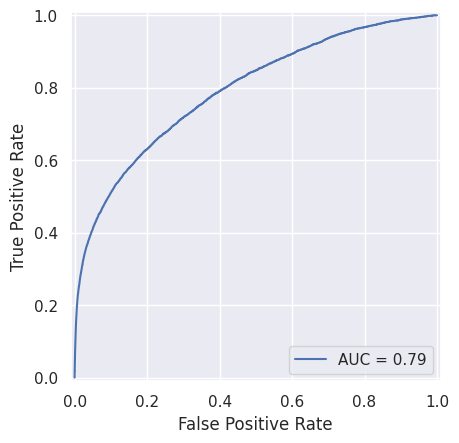

In [14]:
fpr, tpr, thresholds = metrics.roc_curve(predictions['label'], predictions['prediction'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

Text(0, 0.5, 'ROC AUC score (for that test set of size Step)')

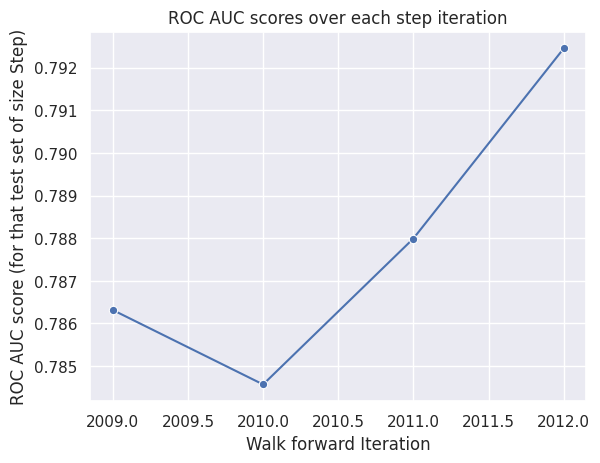

In [15]:
sns.lineplot(x=predictions['group'].unique(), y=stats_list, marker="o")
plt.title('ROC AUC scores over each step iteration')
plt.xlabel('Walk forward Iteration')
plt.ylabel('ROC AUC score (for that test set of size Step)')

In [16]:
default_data_viz = predictions.groupby('group')['label'].mean()

Text(0, 0.5, '% of defaults')

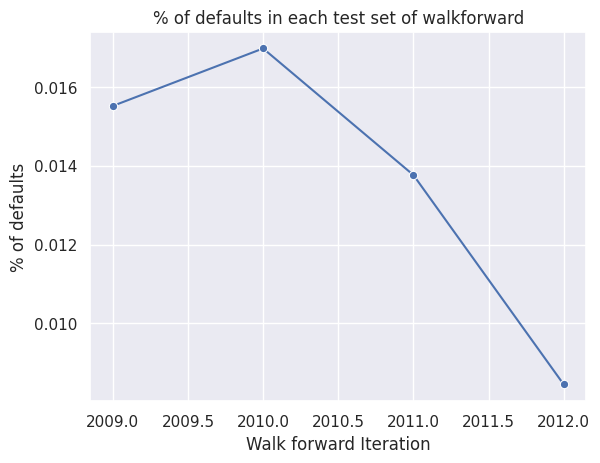

In [17]:
sns.lineplot(x=default_data_viz.index, y=default_data_viz, marker="o")
plt.title('% of defaults in each test set of walkforward')
plt.xlabel('Walk forward Iteration')
plt.ylabel('% of defaults')

In [18]:
stats_list[-1]

0.7924521386487089

In [19]:
last_model = model_list[-1]

In [20]:
print(last_model.rec_fitted_model.summary())

                          Probit Regression Results                           
Dep. Variable:                default   No. Observations:               612920
Model:                         Probit   Df Residuals:                   612910
Method:                           MLE   Df Model:                            9
Date:                Sat, 16 Nov 2024   Pseudo R-squ.:                  0.1815
Time:                        18:30:53   Log-Likelihood:                -38699.
converged:                       True   LL-Null:                       -47280.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -3.3959      0.029   -116.954      0.000      -3.453      -3.339
financial_leverage_quantile_values      1.9607      0.10

In [21]:
print(last_model.first_fitted_model.summary())

                          Probit Regression Results                           
Dep. Variable:                default   No. Observations:               224993
Model:                         Probit   Df Residuals:                   224985
Method:                           MLE   Df Model:                            7
Date:                Sat, 16 Nov 2024   Pseudo R-squ.:                  0.1104
Time:                        18:30:54   Log-Likelihood:                -11353.
converged:                       True   LL-Null:                       -12761.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -3.1272      0.051    -61.891      0.000      -3.226      -3.028
financial_leverage_quantile_values      2.2339      0.20

In [22]:
for year in predictions['group'].unique():
    preds = predictions[predictions['group']==year]['prediction']
    true = predictions[predictions['group']==year]['label']
    print(year, metrics.roc_auc_score(y_true=true, y_score=preds))

2009.0 0.7863160007949944
2010.0 0.7844445138459162
2011.0 0.8019191718267438
2012.0 0.844809502023343


# XGBoost WF

In [23]:
from xgboost import XGBClassifier

In [24]:
def walk_forward_xgb(df, start, date_col = 'Date', step_size = 1):
    predictions = []
    model_list = []
    group_list = []

    stats_list = []
    def_percent = []

    labels = []

    ### features for first firm
    first_features = [
        # 'asst_tot_quantile_values', ####
        'financial_leverage_quantile_values',
        'profitability_ratio_quantile_values',
        # 'net_income_growth_quantile_values',
        'quick_ratio_v2_quantile_values',
        # 'sales_growth_quantile_values',
        # 'cash_assets_ratio_quantile_values', ####
        'dscr_quantile_values',
        'roe_quantile_values',
        'cfo_quantile_values',
        # 'ebitda',
        # 'ateco_sector_pd',
        # 'sector_group_pd', ####
        # 'legal_struct_pd',
        'regional_code_pd' ####
    ]


    ### features for recurring firms
    rec_features = [
        # 'asst_tot_quantile_values', ###
        'financial_leverage_quantile_values',
        'profitability_ratio_quantile_values',
        'net_income_growth_quantile_values',
        'quick_ratio_v2_quantile_values',
        'sales_growth_quantile_values',
        # 'cash_assets_ratio_quantile_values',###
        'dscr_quantile_values',
        'roe_quantile_values',
        'cfo_quantile_values',
        # 'ebitda', ###
        # 'ateco_sector_pd',###
        # 'sector_group_pd',###
        # 'legal_struct_pd',###
        'regional_code_pd'
    ]


    with open('quantile_custom_bins.pkl', 'rb') as file:
        custom_bins = pickle.load(file)

    preproc_params = {
        'quantile_bins' : {},
        'quantile_values' : {},
        'category_pd': {}
    }

    # df[date_col] = pd.to_datetime(df[date_col])
    # walk_range = df[date_col].dt.year.unique()
    walk_range = df['fs_year'].unique()

    for i in range(start,len(walk_range), step_size):
        print(stats_list)

        train_idx = walk_range[:i]
        test_idx = [walk_range[i]]
        print('Training range:',train_idx)
        print('Test step:',test_idx)

        # print('train',train_idx)
        # print('test',test_idx)

        # train_data = df[df[date_col].dt.year.isin(train_idx)].copy()
        # test_data = df[df[date_col].dt.year.isin(test_idx)].copy()
        train_data = df[df['fs_year'].isin(train_idx)].copy()
        test_data = df[df['fs_year'].isin(test_idx)].copy()
        print(train_data.shape)
        print(test_data.shape)

        train_data_proc , preproc_params =pre_process(train_data,
                                                       custom_bins=custom_bins,
                                                       preproc_params = preproc_params,
                                                       quantiles = 50,
                                                       days_until_statement = 150)
        # test_data_proc , preproc_params = preprocessor(test_data, preproc_params, new=False)
        test_data_proc , preproc_params =pre_process(test_data,
                                                     historical_df=train_data_proc,
                                                     new=False,
                                                     preproc_params = preproc_params,
                                                     quantiles = 50,
                                                     days_until_statement = 150)
        print(train_data_proc['default'].mean())
        print(test_data_proc['default'].mean())

        # print(train_data_proc['is_first_occurrence'].value_counts())
        # print(test_data_proc['is_first_occurrence'].value_counts())
        params = {
            "objective": "binary:logistic",
            "eval_metric": "logloss",
            "eta": 0.1,
            "max_depth": 6,
            "min_child_weight": 1,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "gamma": 0,
            "alpha": 0,
            "lambda": 1,
        }

        rec_bst = XGBClassifier(**params, n_estimators=100)
        first_bst = XGBClassifier(**params, n_estimators=100)

        rec_train_data = train_data_proc[train_data_proc['is_first_occurrence']==0]
        first_train_data = train_data_proc[train_data_proc['is_first_occurrence']==1]

        rec_test_data = test_data_proc[test_data_proc['is_first_occurrence']==0]
        first_test_data = test_data_proc[test_data_proc['is_first_occurrence']==1]


        rec_bst = rec_bst.fit(X=rec_train_data[rec_features],
                   y=rec_train_data['default'])

        first_bst = first_bst.fit(X=first_train_data[first_features],
                           y=first_train_data['default'])


        rec_preds = rec_bst.predict_proba(rec_test_data[rec_features])[:,1]
        rec_test_results = rec_test_data[['default']].copy()
        rec_test_results['predictions'] = rec_preds

        first_preds = first_bst.predict_proba(first_test_data[first_features])[:,1]
        first_test_results = first_test_data[['default']].copy()
        first_test_results['predictions'] = first_preds

        prediction = pd.concat([rec_test_results,first_test_results]).reindex(test_data_proc.index)

        model = (rec_bst,first_bst)

        labels += list(prediction['default'].values)
        predictions += list(prediction['predictions'].values)
        group_list += test_idx * len(prediction)

        preds = pd.DataFrame([labels,predictions,group_list]).T
        preds.columns = ['label','prediction','group']

        score = metrics.roc_auc_score(y_score=preds['prediction'], y_true=preds['label'])

        stats_list.append(score)
        model_list.append(model)

        progress_bar(i, len(walk_range))

    predictions = pd.DataFrame([labels,predictions,group_list]).T
    predictions.columns = ['label','prediction','group']
    #predictions.set_index('index', inplace=True)

    return(predictions, model_list, stats_list)

In [25]:
xgb_predictions, xgb_model_list, xgb_stats_list = walk_forward_xgb(modeling_df,
                                                           date_col = 'stmt_date',
                                                           start = 2,
                                                           step_size = 1)

'[▥▥▥▥▥▥▥▥▥▥]  Completed 6 Steps.'

In [26]:
from calibrator import calibrator

In [35]:
xgb_model_list

[(XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=0.8, device=None, early_stopping_rounds=None,
                enable_categorical=False, eta=0.1, eval_metric='logloss',
                feature_types=None, gamma=0, grow_policy=None,
                importance_type=None, interaction_constraints=None, lambda=1,
                learning_rate=None, max_bin=None, max_cat_threshold=None,
                max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
                max_leaves=None, min_child_weight=1, missing=nan,
                monotone_constraints=None, multi_strategy=None, n_estimators=100, ...),
  XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=0.8, device=None, early_stopping_rounds=None,
                enable_categorical=False, eta=0.1, eval

In [27]:
xgb_predictions

,label,prediction,group
0,0.0,0.009501,2009.0
1,0.0,0.035666,2009.0
2,0.0,0.003751,2009.0
3,0.0,0.005500,2009.0
4,0.0,0.005430,2009.0
...,...,...,...
717156,0.0,0.012206,2012.0
717157,0.0,0.004045,2012.0
717158,0.0,0.013140,2012.0
717159,0.0,0.038763,2012.0


In [28]:
xgb_predictions['calibrated_prediction_new'] = xgb_predictions['prediction'].apply(lambda x: calibrator(x))
xgb_predictions

,label,prediction,group,calibrated_prediction_new
0,0.0,0.009501,2009.0,0.020432
1,0.0,0.035666,2009.0,0.074440
2,0.0,0.003751,2009.0,0.008121
3,0.0,0.005500,2009.0,0.011884
4,0.0,0.005430,2009.0,0.011732
...,...,...,...,...
717156,0.0,0.012206,2012.0,0.026168
717157,0.0,0.004045,2012.0,0.008756
717158,0.0,0.013140,2012.0,0.028140
717159,0.0,0.038763,2012.0,0.080621


In [29]:
xgb_sorted = xgb_predictions.sort_values(by='prediction').reset_index(drop=True)

In [30]:
xgb_sorted

,label,prediction,group,calibrated_prediction_new
0,0.0,0.000099,2009.0,0.000215
1,0.0,0.000107,2009.0,0.000233
2,0.0,0.000110,2009.0,0.000238
3,0.0,0.000111,2011.0,0.000242
4,0.0,0.000116,2009.0,0.000252
...,...,...,...,...
717156,0.0,0.769448,2010.0,0.878897
717157,1.0,0.770517,2009.0,0.879538
717158,1.0,0.770936,2009.0,0.879789
717159,0.0,0.774370,2012.0,0.881841


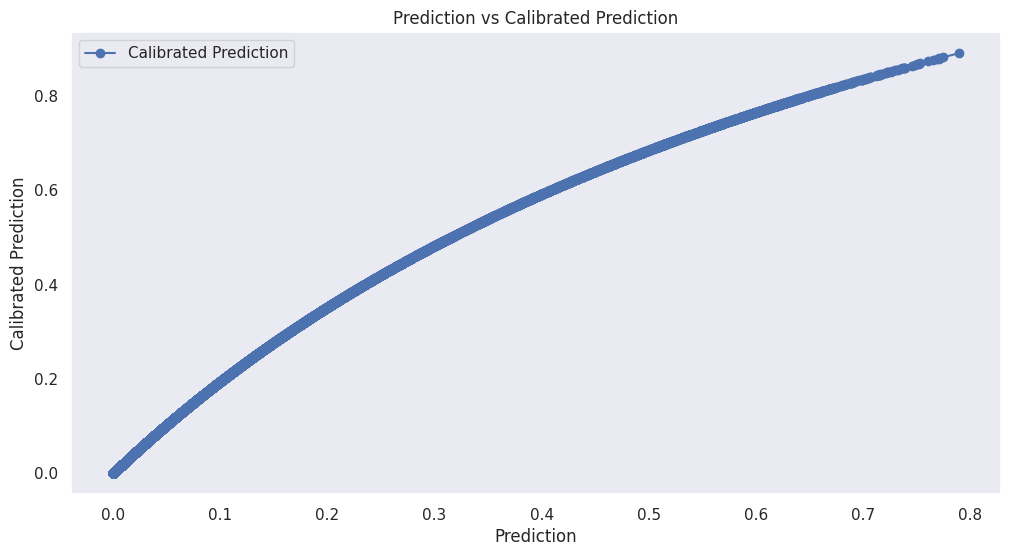

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(xgb_sorted['prediction'], xgb_sorted['calibrated_prediction_new'], label='Calibrated Prediction', marker='o')
plt.xlabel('Prediction')
plt.ylabel('Calibrated Prediction')
plt.title('Prediction vs Calibrated Prediction')
plt.legend()
plt.grid()
plt.show()

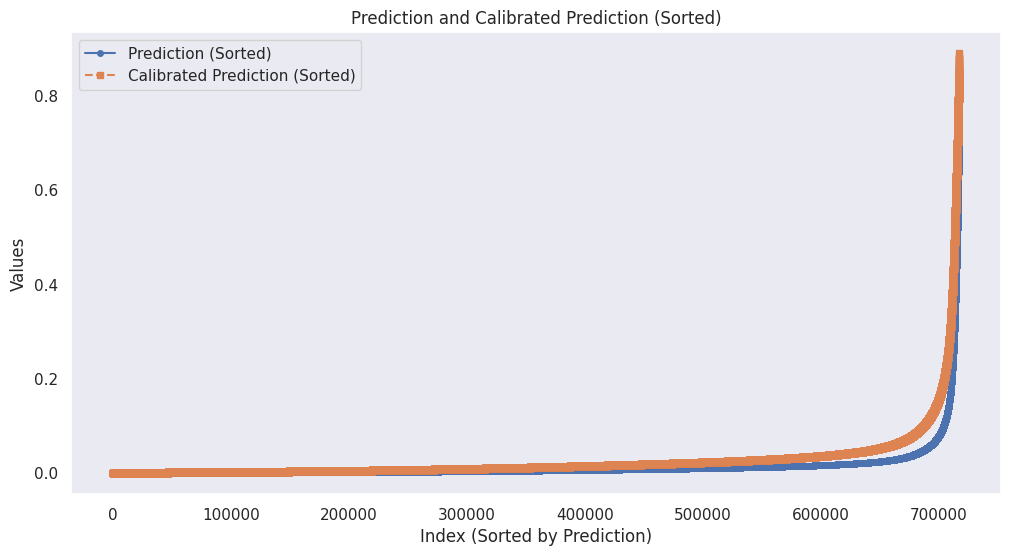

In [32]:


# Plot prediction and calibrated prediction as two separate lines
plt.figure(figsize=(12, 6))
plt.plot(xgb_sorted['prediction'], label='Prediction (Sorted)', marker='o', linestyle='-', markersize=4)
plt.plot(xgb_sorted['calibrated_prediction_new'], label='Calibrated Prediction (Sorted)', marker='s', linestyle='--', markersize=4)
plt.xlabel('Index (Sorted by Prediction)')
plt.ylabel('Values')
plt.title('Prediction and Calibrated Prediction (Sorted)')
plt.legend()
plt.grid()
plt.show()

In [33]:
xgb_predictions['calibrated_prediction_new'].mean()

0.027077444360910276

In [34]:
xgb_predictions['prediction'].mean()

0.013923223319000722

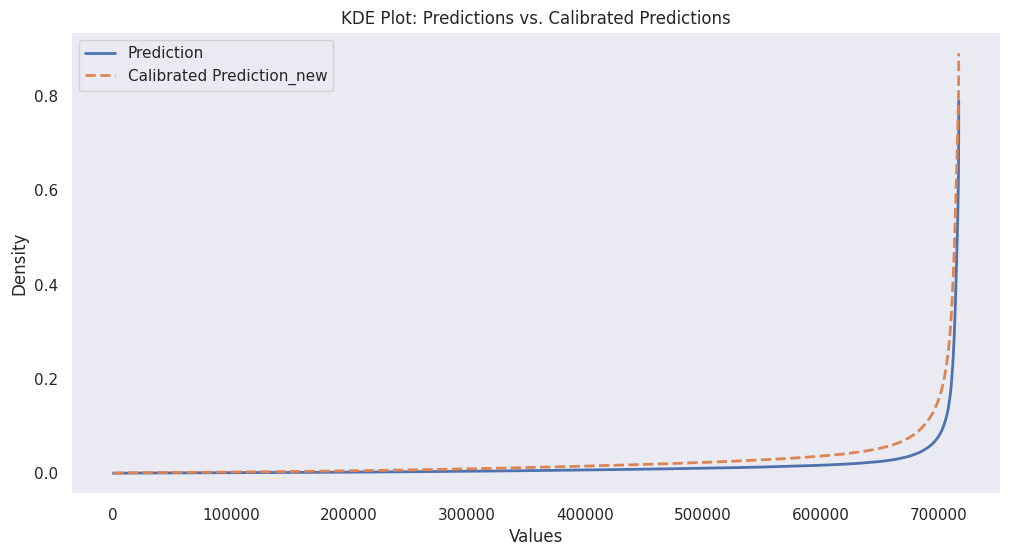

In [41]:
# Plot Kernel Density Estimation (KDE) for predictions and calibrated predictions
plt.figure(figsize=(12, 6))

# KDE plot for predictions
plt.plot(xgb_sorted['prediction'], label='Prediction', linestyle='-', linewidth=2)

# KDE plot for calibrated predictions
plt.plot(xgb_sorted['calibrated_prediction_new'], label='Calibrated Prediction_new', linestyle='--', linewidth=2)

# Add labels, title, and legend
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('KDE Plot: Predictions vs. Calibrated Predictions')
plt.legend()
plt.grid()
plt.show()


ROC AUC 0.8187241380008815


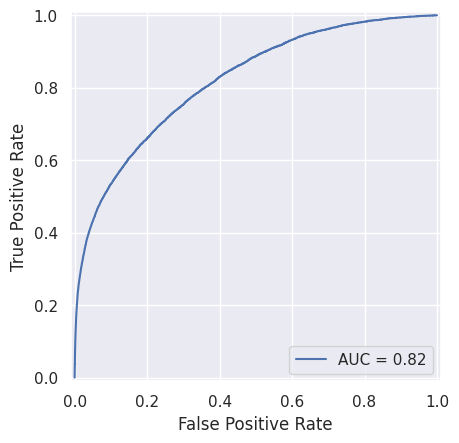

In [64]:
fpr, tpr, thresholds = metrics.roc_curve(xgb_predictions['label'], xgb_predictions['calibrated_prediction'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

Text(0, 0.5, 'ROC AUC score (for that test set of size Step)')

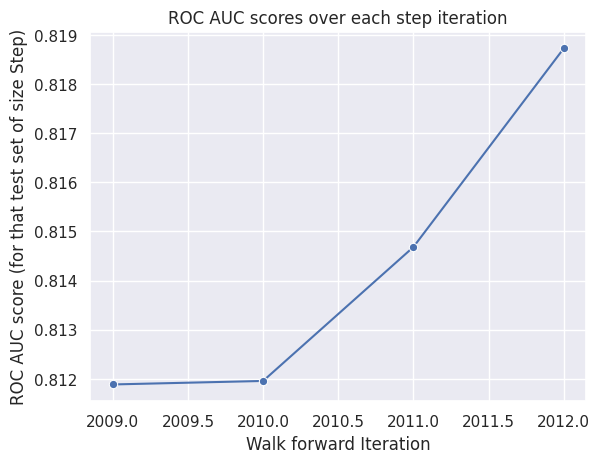

In [35]:
sns.lineplot(x=xgb_predictions['group'].unique(), y=xgb_stats_list, marker="o")
plt.title('ROC AUC scores over each step iteration')
plt.xlabel('Walk forward Iteration')
plt.ylabel('ROC AUC score (for that test set of size Step)')

In [36]:
default_data_viz = xgb_predictions.groupby('group')['label'].mean()

Text(0, 0.5, '% of defaults')

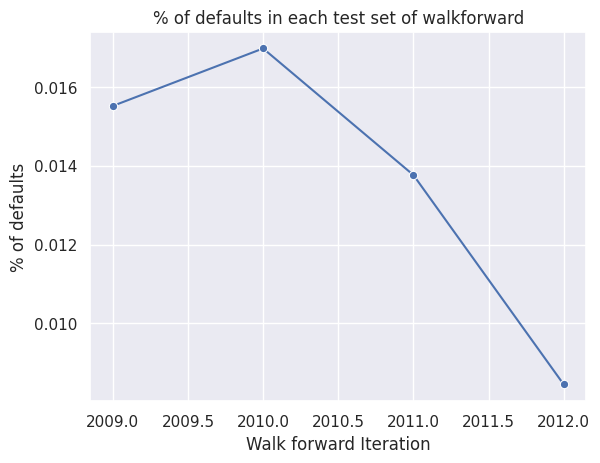

In [37]:
sns.lineplot(x=default_data_viz.index, y=default_data_viz, marker="o")
plt.title('% of defaults in each test set of walkforward')
plt.xlabel('Walk forward Iteration')
plt.ylabel('% of defaults')

In [38]:
xgb_stats_list[-1]

0.8187241380008815

In [39]:
last_model = xgb_model_list[-1]

In [38]:
last_model

In [40]:
for year in xgb_predictions['group'].unique():
    preds = xgb_predictions[xgb_predictions['group']==year]['prediction']
    true = xgb_predictions[xgb_predictions['group']==year]['label']
    print(year, metrics.roc_auc_score(y_true=true, y_score=preds))

2009.0 0.8118876140489647
2010.0 0.8123763089228054
2011.0 0.825642503985851
2012.0 0.8649208147166816


# Comparison

In [ ]:
# xgb_predictions

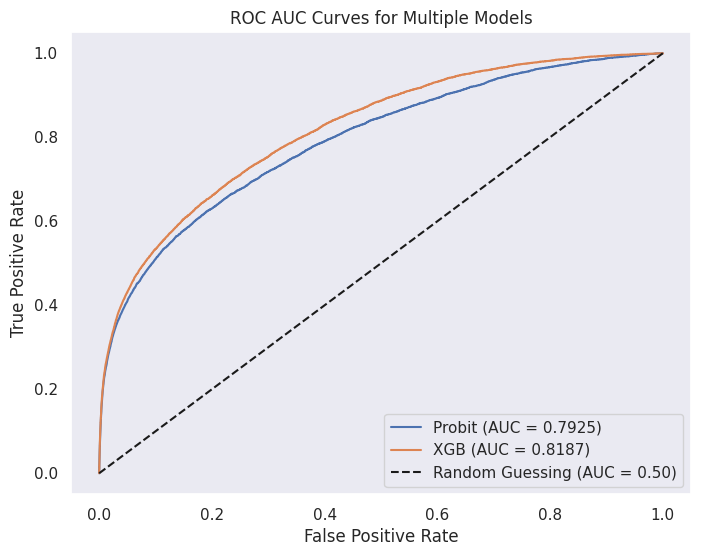

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming df1, df2, and df3 are your three DataFrames with true labels and predictions
dataframes = [predictions ,xgb_predictions,]
labels = ["Probit", "XGB"]

plt.figure(figsize=(8, 6))

for i, df in enumerate(dataframes):
    # Replace 'true_labels' and 'predictions' with the actual column names in your DataFrames
    fpr, tpr, _ = roc_curve(df['label'], df['prediction'])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for the current model
    plt.plot(fpr, tpr, label=f"{labels[i]} (AUC = {roc_auc:.4f})")

# Plot the random guessing line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.50)')

# Labels, title, and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC Curves for Multiple Models")
plt.legend(loc="lower right")
plt.grid()
plt.show()